In [24]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import sys
import numpy as np

# parser = argparse.ArgumentParser(description='VAE MNIST Example')
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')


batch_size = 64
seed = 1
epochs = 10
log_interval = 10
cuda = True
torch.manual_seed(seed)
device = torch.device("cuda:0")

In [25]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Ds_train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('./data/mnist', train=True, download=False,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True, **kwargs)

#Ds train dataset and loader, use only 2000 source samples as few shot learning 2017 paper
Ds =datasets.MNIST('./data/mnist', train=True, download=False,
                   transform=transforms.ToTensor())

Ds_train,_ = torch.utils.data.random_split(Ds, [2000,len(Ds)-2000])
Ds_train_loader = torch.utils.data.DataLoader(Ds_train, batch_size=batch_size, shuffle=True, **kwargs)
Ds_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/mnist', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)




# Dt_train_loader = torch.utils.data.DataLoader(
#     datasets.SVHN('./data/SVHN', split='train', download=True,
#                    transform=transforms.Compose([
#                        transforms.Resize((28,28)),
#                    transforms.ToTensor(),
#                                                 ])),
#     batch_size=batch_size, shuffle=True, **kwargs)

# target dataset
D = datasets.SVHN('./data/SVHN', split='train', download=True,
                   transform=transforms.Compose([
                       transforms.Grayscale(),
                       transforms.Resize((28,28)),
                   transforms.ToTensor(), ]))
# use only 1800 unsupervised target samples and 10 labled target samples
Du_train,Dt_train,_ = torch.utils.data.random_split(D, [1800, 10,len(D)-1800-10])
# few shot dataloader
Dt_train_loader = torch.utils.data.DataLoader(Dt_train,batch_size=batch_size, shuffle=True, **kwargs)
  
# many unsupervised data points
Du_train_loader = torch.utils.data.DataLoader(Du_train, batch_size=batch_size, shuffle=True, **kwargs)

print ('mnsit train',len(Ds_train),'svhn train unlabled', len(Du_train),'svhn labled train', len(Dt_train))

# sys.exit()
Du_test_loader = torch.utils.data.DataLoader(
    datasets.SVHN('./data/SVHN', split='test',
                   transform=transforms.Compose([
                       transforms.Grayscale(),
                       transforms.Resize((28,28)),
                         transforms.ToTensor(),
                                                ])),
    batch_size=batch_size, shuffle=False, **kwargs)


Using downloaded and verified file: ./data/SVHN\train_32x32.mat
mnsit train 2000 svhn train unlabled 1800 svhn labled train 10


In [26]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    
class DCD(nn.Module):
    def __init__(self,h_features=400,input_features=784):
        super(DCD,self).__init__()

        self.fc1=nn.Linear(input_features,h_features)
        self.fc2=nn.Linear(h_features,h_features)
        self.fc3=nn.Linear(h_features,11)

    def forward(self,inputs):
        out=F.relu(self.fc1(inputs))
        out=self.fc2(out)
        return F.softmax(self.fc3(out),dim=1)

VAE = VAE().to(device)
Dw = DCD().to(device)
optimizerVAE = optim.Adam(VAE.parameters() , lr=1e-3)
optimizerDw = optim.Adam(Dw.parameters(), lr=1e-3)




In [27]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # uses mean and variance over all elements
    
    #+ classification loss categorical cross entropy

    return BCE + KLD


In [28]:
def trainvae(epoch):
    VAE.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(Ds_train_loader):
        data = data.to(device)
        optimizerVAE.zero_grad()
        recon_batch, mu, logvar = VAE(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizerVAE.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(Ds_train_loader.dataset),
                100. * batch_idx / len(Ds_train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(Ds_train_loader.dataset)))


def testvae(epoch):
    VAE.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(Ds_test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = VAE(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()
            if i == 0:
                n = min(data.size(0), 8)
                comparison = torch.cat([data[:n],
                                      recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                         'results_variational_ae/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(Ds_test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))
    

In [29]:
for epoch in range(1, epochs + 1):
    trainvae(epoch)
    testvae(epoch)
#     with torch.no_grad():
    #     sample = torch.randn(64, 200).to(device)
    #     sample = model.decode(sample).cpu()
    #     save_image(sample.view(64, 1, 28, 28),
    #                'results_variational_ae/sample_' + str(epoch) + '.png')

Train Epoch: 1 [0/2000 (0%)]	Loss: 549.107178
Train Epoch: 1 [640/2000 (31%)]	Loss: 304.279724
Train Epoch: 1 [1280/2000 (62%)]	Loss: 239.824249
Train Epoch: 1 [1920/2000 (94%)]	Loss: 217.529266
====> Epoch: 1 Average loss: 302.6394
====> Test set loss: 219.1784
Train Epoch: 2 [0/2000 (0%)]	Loss: 218.853027
Train Epoch: 2 [640/2000 (31%)]	Loss: 207.368057
Train Epoch: 2 [1280/2000 (62%)]	Loss: 207.107300
Train Epoch: 2 [1920/2000 (94%)]	Loss: 188.289154
====> Epoch: 2 Average loss: 211.0455
====> Test set loss: 203.1200
Train Epoch: 3 [0/2000 (0%)]	Loss: 194.178665
Train Epoch: 3 [640/2000 (31%)]	Loss: 186.165802
Train Epoch: 3 [1280/2000 (62%)]	Loss: 198.458618
Train Epoch: 3 [1920/2000 (94%)]	Loss: 199.438263
====> Epoch: 3 Average loss: 195.1890
====> Test set loss: 188.5900
Train Epoch: 4 [0/2000 (0%)]	Loss: 187.772491
Train Epoch: 4 [640/2000 (31%)]	Loss: 187.842300
Train Epoch: 4 [1280/2000 (62%)]	Loss: 183.689819
Train Epoch: 4 [1920/2000 (94%)]	Loss: 176.615112
====> Epoch: 4 A

In [30]:

# CEL = nn.CrossEntropyLoss()
def loss_function_dw2(preds, targets):
    print (preds)
    CEL_s = F.cross_entropy(preds, targets)

    return CEL_s

def loss_function_dw(ds,du,target_ds,target_du):
#     print ('ds',ds, target_ds)
#     print ('du',du, target_du)
    CEL_s = F.cross_entropy(ds, target_ds)
    CEL_u = F.cross_entropy(du, target_du)
#     BCE_s = F.binary_cross_entropy(ds, target_ds)
#     BCE_u = F.binary_cross_entropy(du, target_du)
#     print ('s', CEL_s)
#     print ('u',CEL_u)
#     sys.exit()
    return CEL_s + CEL_u


def traindw(epoch):
    VAE.eval()
    Dw.train()
    train_loss = 0
    for batch_idx, (Ds, Du) in enumerate(zip(Ds_train_loader,Du_train_loader)):

        Ds_x,target_s = Ds
        Du_x, target_u = Du
#         print (Ds_x.shape,Du_x.shape, target_s.shape,target_u.shape)

        target_u = torch.LongTensor(np.array([10]*len(target_u)))
        Ds_x = Ds_x.to(device)
        Du_x = Du_x.to(device)
        target_s = target_s.to(device)
        target_u = target_u.to(device)
        optimizerDw.zero_grad()
        Ds_embedding, mus, logvars = VAE(Ds_x)
        Du_embedding, muu, logvaru = VAE(Du_x)
        
        
        
        Ds_pred = Dw(Ds_embedding)
        Du_pred = Dw(Du_embedding)
#         print (target_s.shape, Ds_embedding.shape,Du_embedding.shape, Ds_pred.shape, Du_pred.shape)
#         preds = torch.cat((Ds_pred, Du_pred), 0)
#         targets = torch.cat((target_s, target_u), 0)
#         print (preds.shape, targets.shape)
#         print (targets)
#         sys.exit()
        loss = loss_function_dw(Ds_pred, Du_pred,target_s, target_u)
#         loss = loss_function_dw2(preds, targets)
#         print (loss)
#         print (loss)


        loss.backward()
        train_loss += loss.item()
        optimizerDw.step()

        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(Ds_x), len(Ds_train_loader.dataset),
                100. * batch_idx / len(Ds_train_loader),
                loss.item()))
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / batch_idx))
# traindw(9)


def testdw(epoch):
    VAE.eval()
    Dw.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (Ds, Du) in enumerate(zip(Ds_test_loader,Du_test_loader)):
            Ds_x,target_s = Ds
            Du_x, target_u = Du
    #         print (Ds_x.shape,Du_x.shape, target_s.shape,target_u.shape)

            target_u = torch.LongTensor(np.array([10]*len(target_u)))
            Ds_x = Ds_x.to(device)
            Du_x = Du_x.to(device)
            target_s = target_s.to(device)
            target_u = target_u.to(device)
            Ds_embedding, mus, logvars = VAE(Ds_x)
            Du_embedding, muu, logvaru = VAE(Du_x)
            Ds_pred = Dw(Ds_embedding)
            Du_pred = Dw(Du_embedding)
            test_loss += loss_function_dw(Ds_pred, Du_pred,target_s, target_u).item()
            # make sure that the loss is calculated ccorrectly

    test_loss /= i #len(Ds_test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [31]:
for epoch in range(1,epochs + 1):
    traindw(epoch)
    testdw(epoch)

Train Epoch: 1 [0/2000 (0%)]	Loss: 4.785554
Train Epoch: 1 [640/2000 (31%)]	Loss: 4.078124
Train Epoch: 1 [1280/2000 (62%)]	Loss: 3.952308
====> Epoch: 1 Average loss: 4.2088
====> Test set loss: 3.8081
Train Epoch: 2 [0/2000 (0%)]	Loss: 3.736668
Train Epoch: 2 [640/2000 (31%)]	Loss: 3.614134
Train Epoch: 2 [1280/2000 (62%)]	Loss: 3.606181
====> Epoch: 2 Average loss: 3.7470
====> Test set loss: 3.5674
Train Epoch: 3 [0/2000 (0%)]	Loss: 3.511666
Train Epoch: 3 [640/2000 (31%)]	Loss: 3.536886
Train Epoch: 3 [1280/2000 (62%)]	Loss: 3.470229
====> Epoch: 3 Average loss: 3.6389
====> Test set loss: 3.5275
Train Epoch: 4 [0/2000 (0%)]	Loss: 3.478965
Train Epoch: 4 [640/2000 (31%)]	Loss: 3.536520
Train Epoch: 4 [1280/2000 (62%)]	Loss: 3.500050
====> Epoch: 4 Average loss: 3.6053
====> Test set loss: 3.4962
Train Epoch: 5 [0/2000 (0%)]	Loss: 3.463677
Train Epoch: 5 [640/2000 (31%)]	Loss: 3.486024
Train Epoch: 5 [1280/2000 (62%)]	Loss: 3.428740
====> Epoch: 5 Average loss: 3.5840
====> Test se

In [32]:
    Dw.eval()
    VAE.eval()
    test_loss = 0
    import numpy as np
    import sys
    Ds_source = []
    Ds_target_vector =  []
    Dw_preds_vector = []
    Dw_targets_vector = []
    
    

    with torch.no_grad():
        for i, (Ds, Du) in enumerate(zip(Ds_test_loader,Du_test_loader)):
            Ds_x,target_s = Ds
            Du_x, target_u = Du
            
            target_u = torch.LongTensor(np.array([10]*len(target_u)))
            Ds_x = Ds_x.to(device)
            Du_x = Du_x.to(device)
            target_s = target_s.to(device)
            target_u = target_u.to(device)
            Ds_embedding, mus, logvars = VAE(Ds_x)
            Du_embedding, muu, logvaru = VAE(Du_x)
            Ds_pred = Dw(Ds_embedding)
            Du_pred = Dw(Du_embedding)
            
            Dw_preds = torch.cat((Ds_pred, Du_pred), 0)
            Dw_targets = torch.cat((target_s, target_u), 0)

#             print (recon_batch.shape, mu.shape, logvar.shape)
            for i in range(len(target_s)+len(target_u)):
                Dw_preds_vector.append(Dw_preds[i].cpu().detach().tolist())
                Dw_targets_vector.append(Dw_targets[i].cpu().detach().tolist())
#                 source.append(recon_batch[i].cpu().detach().tolist())
#                 target_vector.append(target[i].cpu().detach().tolist())
#                 mu_vector.append(mu[i].cpu().detach().tolist())

print (np.array(Dw_preds_vector).shape, np.array(Dw_targets_vector).shape)  

(20048, 11) (20048,)


In [33]:
    # We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Random state.
RS = 20150101
no = 200
new_feature_stack = np.array(Dw_preds_vector[:no] + Dw_preds_vector[-no:])
# new_mu_stack = np.array(mu_vector[:no] + mu_vector[-no:])   
print (len(new_feature_stack))
digits_proj = TSNE(random_state=RS).fit_transform(new_feature_stack)
# mu_proj = TSNE(random_state=RS).fit_transform(new_mu_stack)
new_labels_vector = np.array(Dw_targets_vector[:no] + Dw_targets_vector[-no:])
print (new_feature_stack.shape)
print (new_labels_vector.shape)
# print (new_mu_stack.shape)

400
(400, 11)
(400,)


[ 6  0  9  1  7  1  3  6  6  0  7  3  7  2  8  4  3  7  1  7  8  7  0  4
  7  7  2  3  5  1  1  4  2  3  6  3  0  2  3  3  6  0  4  5  3  9  2  3
  5  3  2  1  1  2  4  9  1  2  9  0  7  3  9  5 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10  7  7  6  0  4  1  1  3  4  7  6  8  9  6  7  6
  2  2  7  3  4  0  5  9  4  2  2  8  3  0  9  4  8  8  9  7  4  6  6  8
  8  7  2  7  8  3  6  8  4  1  0  3  2  2  9  1  1  5  7  6  4  2  2  9
 10 10 10 10 10 10 10 10  0  3  5  6  9  4  2  6  0  8  7  3  2  2  3  4
  1  1  5  1  4  1  8  5  2  0  5  8  4  3  3  8  1  3  7  3  5  6  0  6
  4  5  8  5  9  7  5  8  5  8  8  4  9  1  6  8 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10  2  6  2  6  9  3  8  7  2

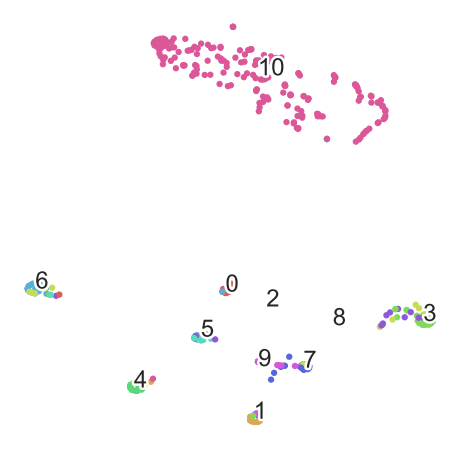

In [34]:
# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 11))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(11):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts
print (new_labels_vector)
scatter(digits_proj, new_labels_vector)
plt.show()

In [17]:
# discriminator input low level domain, output vector size 11 (10 numbers and 1 for if image is 
# from source or target) train by parsing embedded image using encoder Ds
# generate lable for that sample by having lable and adding a 0 if from Ds or 1 form Dt

In [ ]:
# few shot adaptation by adversarial learning 